In [182]:
import xmitgcm
from xmitgcm import open_mdsdataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import xgcm

In [2]:
# function to load in the data
# data_dir is location of data
# prefix is type of data to load in (dyn, layersDiags)
def getoutput(data_dir,prefix):
    deltaTClock = 21600.
    grid_dir = './K50grid/'
    data = open_mdsdataset(data_dir,grid_dir,delta_t=deltaTClock,prefix=prefix,geometry='sphericalpolar',default_dtype=np.dtype)
    return data

In [175]:
# save loaded data to a veriable named after both type of data (dyn, layersDiags) and used kappa (50,500,5000)
# accidently reran kappa 500 with wrong GMKappa so I cut that part off, it reach equilibirum before this.
dyn50=getoutput('./K50/','dyn')
dyn500=getoutput('./K500/','dyn')
dyn5000=getoutput('./K5000/','dyn')
#dyn5000=dyn5000.where(dyn5000['iter']>6.8e6,drop=True).isel(time=slice(29,35)).mean('time')
lay50=getoutput('./K50/','layersDiags')
lay500=getoutput('./K500/','layersDiags')
lay5000=getoutput('./K5000/','layersDiags')
#isel(time=-1)

In [4]:
#Control all font sizes on all plots
matplotlib.rcParams.update({'font.size': 12})

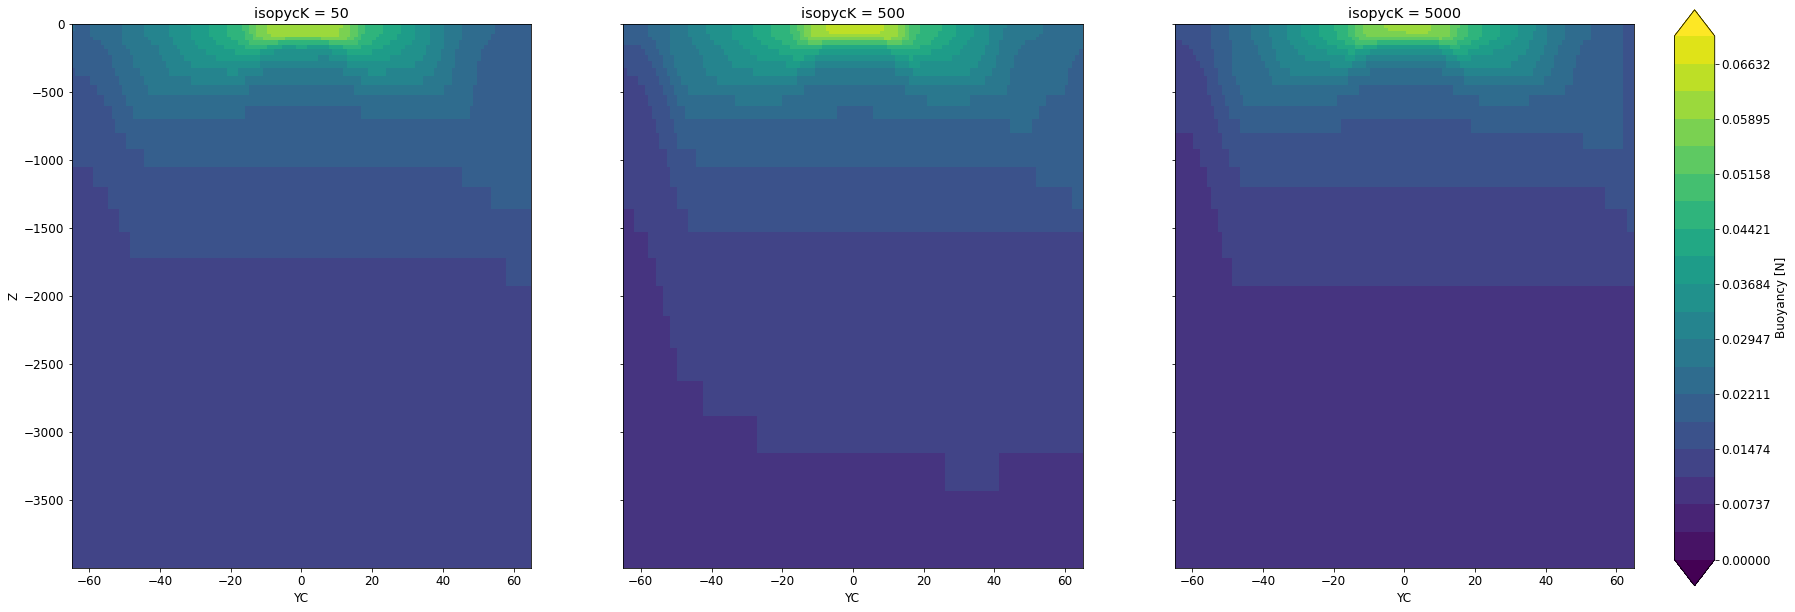

In [34]:
fig, axs = plt.subplots(ncols=3,figsize=(28,10),sharey=True)
bouyancy50=bouy(dyn50)
bouyancy500=bouy(dyn500)
bouyancy5000=bouy(dyn5000)
a=(bouyancy50).plot(ax=axs[0],vmin=0,vmax=0.07,levels=20,extend='both',add_colorbar=False,add_labels=True)
b=(bouyancy500).plot(ax=axs[1],vmin=0,vmax=0.07,levels=20,extend='both',add_colorbar=False)
c=(bouyancy5000).plot(ax=axs[2],vmin=0,vmax=0.07,levels=20,extend='both',add_colorbar=False)
cax = plt.axes([0.92, 0.1, 0.02, 0.8])
plt.colorbar(a, cax=cax,label='Buoyancy [N]')
#plt.title( 'K=50')
axs[1].set_ylabel('')
axs[2].set_ylabel('')
axs[0].set_title('isopycK = 50')
axs[1].set_title('isopycK = 500')
axs[2].set_title('isopycK = 5000')
plt.savefig('Buoyancy.png')

In [26]:
def bouy(dyn):
    weights = dyn['dxF']
    bouy=(9.81*(2e-4*dyn['THETA']-7.4e-4*(dyn['SALT']-35)))[:,:-1,:-1].weighted(weights).sum('XC')/dyn['dxF'].sum('XC')
    return bouy

In [35]:
def coverter(lay):
    weight=lay['dxG']
    density_to_depth = ((lay['LaHs1RHO'].weighted(weight)).sum('XC').cumsum('layer_1RHO_center'))/(lay['dxG'].sum('XC'))
    stream1 = ((lay['LaVH1RHO'].weighted(weight)).sum('XC').cumsum('layer_1RHO_center'))
    layers_depth=lay.LaHs1RHO.mean('XC').cumsum('layer_1RHO_center')
    layers_depth_atl=((lay.LaHs1RHO*lay.dxG).sum('XC')/lay.dxG.sum('XC')).cumsum('layer_1RHO_center')
    stream1.coords['depth']=-layers_depth_atl
    layer_1RHO_center_new = xr.DataArray(layers_depth_atl, dims=['layer_1RHO_bounds','YG'], coords={'layer_1RHO_bounds': lay.layer_1RHO_bounds[:-1],'YG':lay.YG})
    layer2D,_=(xr.broadcast(-9.81*(lay.layer_1RHO_bounds-35)/1035, lay.YG))
    layer2D.coords['depth']=(-layer_1RHO_center_new)
    return stream1,layer2D

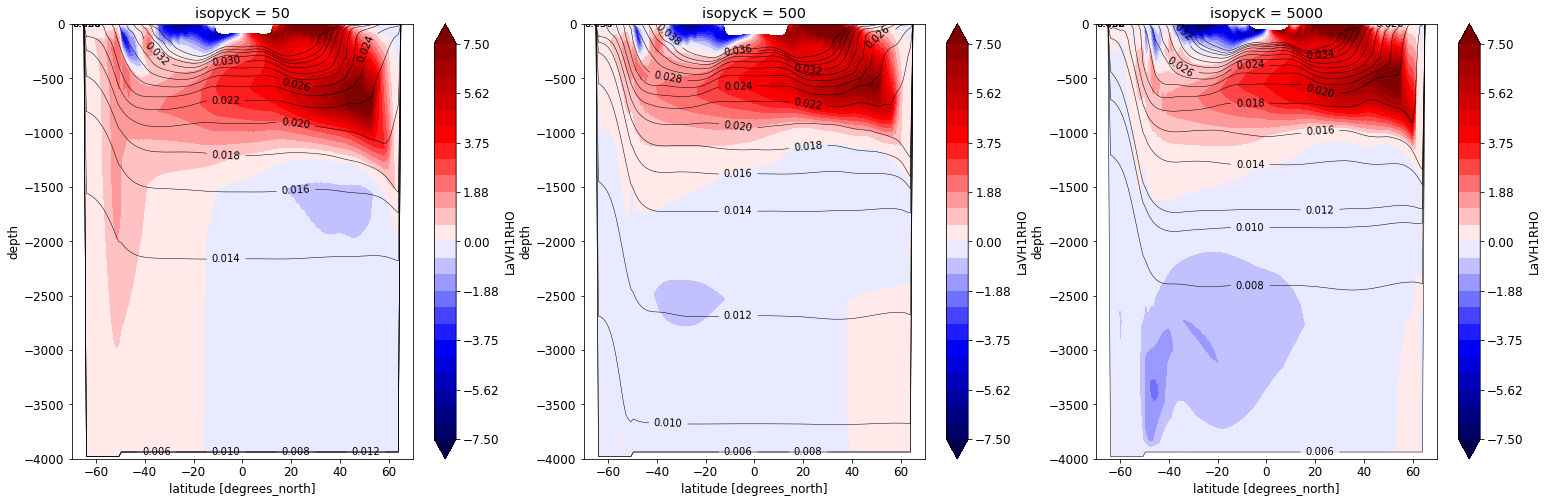

In [65]:
fig, axs = plt.subplots(ncols=3,figsize=(26,8))
mins=-7.5
maxs=7.5
cmap='seismic'
stream50,con50 = coverter(lay50)
stream500, con500 = coverter(lay500)
stream5000, con5000 = coverter(lay5000)
a = (stream50/1e6).plot.contourf(ax=axs[0],x='YG',y='depth',cmap=cmap,xlim=(-70,70),ylim=(-4000,0),vmin=mins,vmax=maxs,extend='both',levels=25,yincrease=False)
b = (stream500/1e6).plot.contourf(ax=axs[1],x='YG',y='depth',cmap=cmap,xlim=(-70,70),ylim=(-4000,0),vmin=mins,vmax=maxs,extend='both',levels=25,yincrease=False)
C = (stream5000/1e6).plot.contourf(ax=axs[2],x='YG',y='depth',cmap=cmap,xlim=(-70,70),ylim=(-4000,0),vmin=mins,vmax=maxs,extend='both',levels=25,yincrease=False)

aa=con50.plot.contour(ax=axs[0],x='YG',y='depth',levels=np.arange(0,0.04,0.002),colors='black',linewidths=0.5)
#con50.plot.contour(ax=axs[0],x='YG',y='depth',levels=np.arange(0.0085,0.4,0.2),colors='black',linewidths=2)
bb=con500.plot.contour(ax=axs[1],x='YG',y='depth',levels=np.arange(0,0.04,0.002),colors='black',linewidths=0.5)
#con500.plot.contour(ax=axs[1],x='YG',y='depth',levels=np.arange(0.0085,0.4,0.2),colors='black',linewidths=2)
cc=con5000.plot.contour(ax=axs[2],x='YG',y='depth',levels=np.arange(0,0.04,0.002),colors='black',linewidths=0.5)
#con5000.plot.contour(ax=axs[2],x='YG',y='depth',levels=np.arange(0.0085,0.4,0.2),colors='black',linewidths=2)
axs[0].clabel(aa, aa.levels, inline=True,  fontsize=10)
axs[1].clabel(bb, bb.levels, inline=True,  fontsize=10)
axs[2].clabel(cc, cc.levels, inline=True,  fontsize=10)
axs[0].set_title('isopycK = 50'),
axs[1].set_title('isopycK = 500')
axs[2].set_title('isopycK = 5000')
plt.savefig('convert_stream.png')

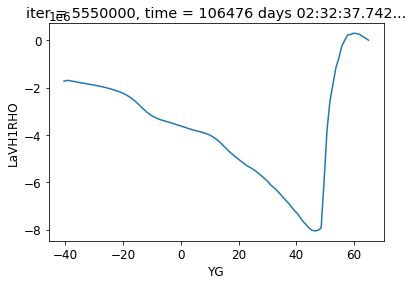

In [168]:
weight=lay50['dxG']
stream = ((lay50['LaVH1RHO'][14:,24:].weighted(weight)).sum('XC').sum('layer_1RHO_center'))
stream.plot()

/scratch/user/nicole.neumann-2/.conda/envs/jupyterenv/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


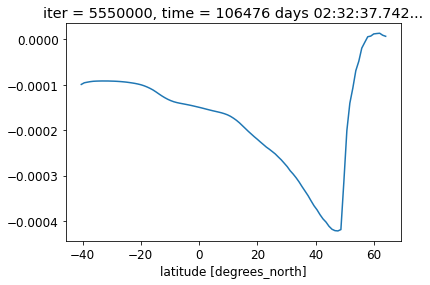

In [172]:
start=14
#fig,ax=plt.subplots(1,1)
thing=(lay50['LaVH1RHO'][start:-1,24:,:].sum('layer_1RHO_center')/lay50['LaHs1RHO'][start:-1,24:,:-1].sum('layer_1RHO_center')).mean('XC')
#ax.set_ylabel('Velocity (m/s)')
#ax.set_ylim(-0.0022,0)
#ax.grid(True)
thing.plot()

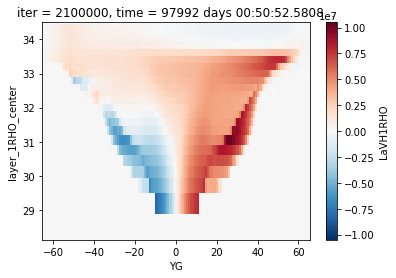

In [50]:
weight=lay50['dxG']
stream1 = ((lay50['LaVH1RHO'].weighted(weight)).sum('XC').cumsum('layer_1RHO_center')[-1])
stream1.plot()

In [101]:
# function to calculate streamfunction in density coordinates
def laystreamfunction(lay):
    weight=lay['dxG']
    stream = ((lay['LaVH1RHO'].weighted(weight)).sum('XC').cumsum('layer_1RHO_center'))
    return stream

In [129]:
stream50=laystreamfunction(lay50)
stream500=laystreamfunction(lay500)
stream5000=laystreamfunction(lay5000)

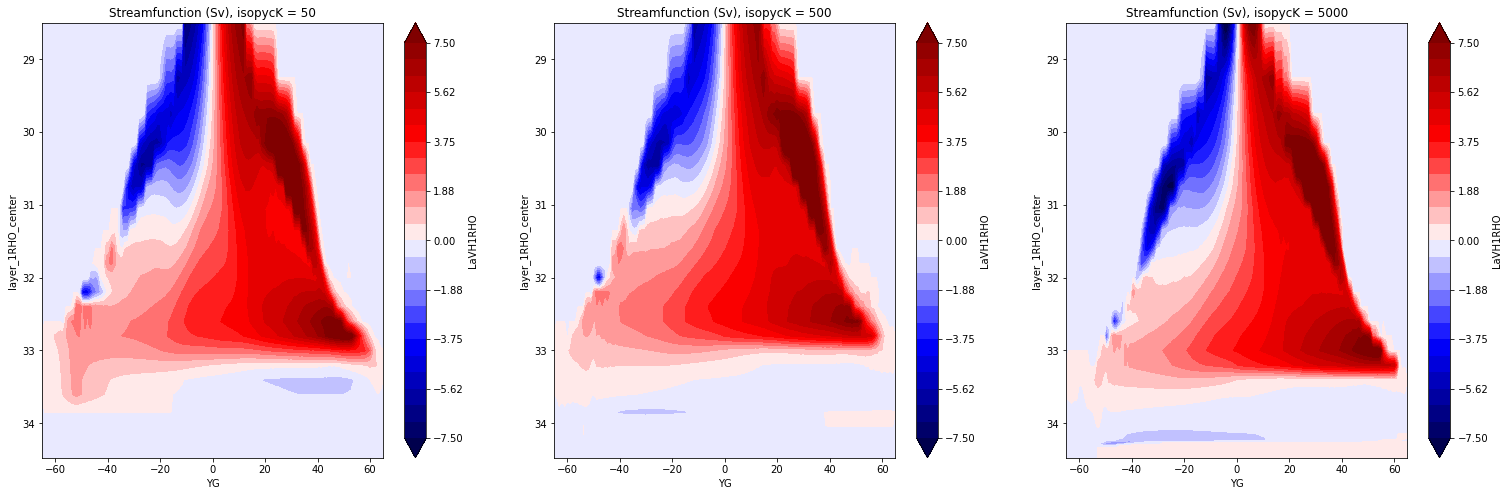

In [130]:
fig, axs = plt.subplots(ncols=3,figsize=(26,8))
#levels = np.arange(-2.5,2.5,.05)
mins=-7.5
maxs=7.5
cmap='seismic'
a = (stream50/1e6).plot.contourf(ax = axs[0],vmin=mins,vmax=maxs,cmap=cmap,extend='both',levels=25,yincrease=False)
b = (stream500/1e6).plot.contourf(ax = axs[1],vmin=mins,vmax=maxs,cmap=cmap,extend='both',levels=25,yincrease=False)
C = (stream5000/1e6).plot.contourf(ax = axs[2],vmin=mins,vmax=maxs,cmap=cmap,extend='both',levels=25,yincrease=False)
axs[0].set_title('Streamfunction (Sv), isopycK = 50'),
axs[1].set_title('Streamfunction (Sv), isopycK = 500')
axs[2].set_title('Streamfunction (Sv), isopycK = 5000')
plt.savefig('stream1.png')

In [131]:
# function to calculate streamfunction in Z coordinates
def dynstreamfunction(dyn):
    weights = dyn['dxG']
    temp=(dyn[['VVEL']]).to_array()
    stream=((temp.weighted(weights).sum('XC'))*temp['drF']).cumsum('Z')[0]
    return stream


In [132]:
MOC50 = dynstreamfunction(dyn50)
MOC500 = dynstreamfunction(dyn500)
MOC5000 = dynstreamfunction(dyn5000)

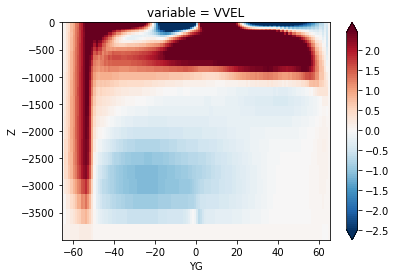

In [128]:
levels = np.arange(-2.5,2.5,.05)
(MOC5000/1e6).plot(levels=levels)
plt.savefig('trough.png')

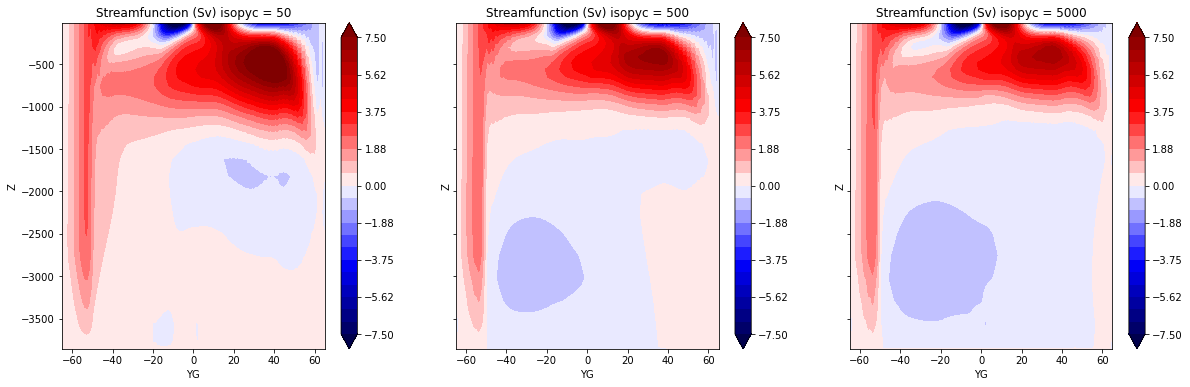

In [133]:
fig, axs = plt.subplots(ncols=3,sharey=True,figsize=(20,6))
mins=-7.5
maxs=7.5
cmap='seismic'
a = (MOC50/1e6).plot.contourf(ax = axs[0],vmin=mins,vmax=maxs,cmap=cmap,extend='both',levels=25)
b = (MOC500/1e6).plot.contourf(ax = axs[1],vmin=mins,vmax=maxs,cmap=cmap,extend='both',levels=25)
c = (MOC5000/1e6).plot.contourf(ax = axs[2],vmin=mins,vmax=maxs,cmap=cmap,extend='both',levels=25)
axs[2].set_title('Streamfunction (Sv) isopyc = 5000')
axs[1].set_title('Streamfunction (Sv) isopyc = 500')
axs[0].set_title('Streamfunction (Sv) isopyc = 50')
plt.savefig('stream.png')

In [180]:
# function to plot the temp vs. time to see if the model reached equalibrium
def equilibrium(dyn):
    weight=dyn['drF']
    weightx=dyn['dxF']
    weighty=dyn['dyF']
    timer = dyn.where(dyn['Z']<-1,drop=True).weighted(weight).mean('Z').weighted(weighty).mean('YC').weighted(weightx).mean('XC')
    timer.plot.scatter(x='iter',y='THETA')
    plt.title('')
    plt.savefig('timestep1.png')

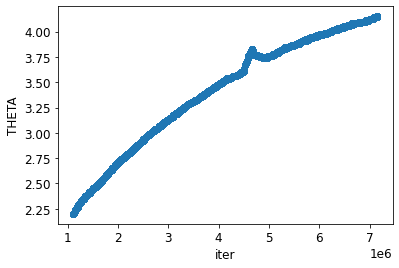

In [181]:
equilibrium(dyn500)

In [22]:
layer=lay50['LaHs1RHO'].isel(time=23).where(lay50['layer_1RHO_center']<=33).sum('layer_1RHO_center')

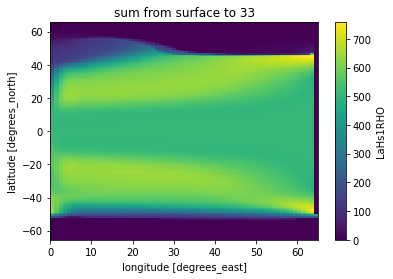

In [23]:
layer.plot()
plt.title('sum from surface to 33')
plt.savefig('layer.png')